# notes:
* tensorflow is very picky about the shape of data, so even you np.ndarray is `(47, )`, you need to reshape it into `(47,1)` to make sure everything goes alright
* the shape of `np.array([1,2,3,4])` is `(4, )`, this is column vector. Be aware of the shape of data.
* Different optimizer have very huge difference between convergence speed in this convex example, [I need to learn more about differences of optimizers](http://sebastianruder.com/optimizing-gradient-descent/)
* Confused about whether I should use row vector or column vector and here is the answer: [Column Vectors Vs. Row Vectors](http://steve.hollasch.net/cgindex/math/matrix/column-vec.html)

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(context="notebook", style="darkgrid", palette="dark")

import sys
sys.path.append('..')

from helper import linear_regression as lr  # my own module
from helper import general as general

# prepare data

In [2]:
raw_data = pd.read_csv('ex1data2.txt', names=['square', 'bedrooms', 'price'])
data = general.normalize_feature(raw_data)
data.insert(loc=0, column='ones', value=1)  # this data.insert happend inplace..

print(data.shape)
data.head()

(47, 4)


,ones,square,bedrooms,price
0,1,0.130010,-0.223675,0.475747
1,1,-0.504190,-0.223675,-0.084074
2,1,0.502476,-0.223675,0.228626
3,1,-0.735723,-1.537767,-0.867025
4,1,1.257476,1.090417,1.595389


In [3]:
X_data = general.get_X(data)
print(X_data.shape, type(X_data))

y_data = general.get_y(data)
y_data = y_data.reshape(len(y_data), 1) # Tensorflow is finicky about shapes, so resize
print(y_data.shape, type(y_data))

(47, 3) <class 'numpy.ndarray'>
(47, 1) <class 'numpy.ndarray'>


# construct a graph

In [4]:
X = tf.placeholder(tf.float32, shape = X_data.shape)
y = tf.placeholder(tf.float32, shape = y_data.shape)

In [5]:
with tf.variable_scope('linear-regression'):
    W = tf.get_variable("weights", 
                        (X_data.shape[1], 1), 
                        initializer=tf.constant_initializer()) # n*1
    
    y_pred = tf.matmul(X, W)  # m*n @ n*1 -> m*1
    
    loss = 1/(2*len(X_data)) * tf.matmul((y_pred - y), (y_pred - y), transpose_a=True)  # (m*1).T @ m*1 = 1*1

# run the session

GD is converged at epoch: 1151
GD
final parameters
 [[  6.50528698e-09]
 [  8.81516397e-01]
 [ -4.99292985e-02]]
final loss=0.13069108128547668

Adagrad
final parameters
 [[  4.65326222e-09]
 [  6.29321277e-01]
 [  1.15429156e-01]]
final loss=0.15294453501701355

RMS is converged at epoch: 215
RMS
final parameters
 [[ 0.00491665]
 [ 0.87982631]
 [-0.05811893]]
final loss=0.13073551654815674

Adam is converged at epoch: 296
Adam
final parameters
 [[ -6.84417678e-09]
 [  8.84003639e-01]
 [ -5.26335016e-02]]
final loss=0.1306867003440857

Ftrl
final parameters
 [[  5.30118083e-09]
 [  6.29321098e-01]
 [  1.15429364e-01]]
final loss=0.15294456481933594



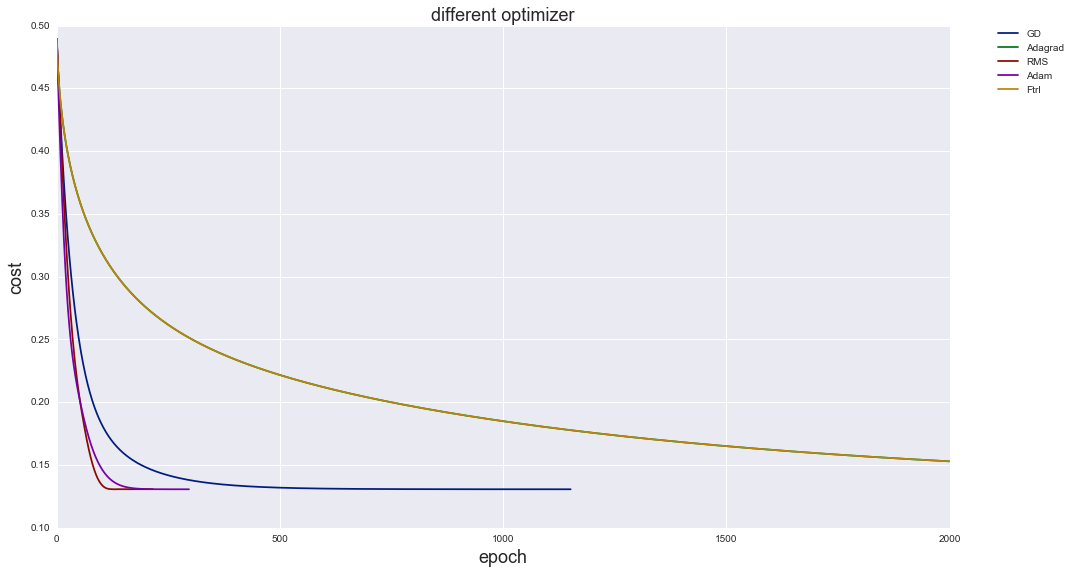

In [6]:
epoch = 2000
alpha = 0.01

optimizer={'GD': tf.train.GradientDescentOptimizer,
           'Adagrad': tf.train.AdagradOptimizer,
           'Adam': tf.train.AdamOptimizer,
           'Ftrl': tf.train.FtrlOptimizer,
           'RMS': tf.train.RMSPropOptimizer
          }

fig, ax = plt.subplots(figsize=(16, 9))

for optimizer_name in optimizer:
    opt = optimizer[optimizer_name](learning_rate=alpha)
    opt_operation = opt.minimize(loss)
    
    with tf.Session() as sess:
        sess.run(tf.initialize_all_variables())
        loss_data = []
        
        for i in range(epoch):
            _, loss_val, W_val = sess.run([opt_operation, loss, W], feed_dict={X: X_data, y: y_data})
            loss_data.append(loss_val[0,0])  # because every loss_val is 1*1 ndarray

            if len(loss_data) > 1 and np.abs(loss_data[-1] - loss_data[-2]) < 10**-9:
                print('{} is converged at epoch: {}'.format(optimizer_name, i))
                break

    ax.plot(np.arange(len(loss_data)), loss_data, label = optimizer_name)
    
    print(optimizer_name)
    print('final parameters\n', W_val)
    print('final loss={}\n'.format(loss_val[0,0]))

ax.set_xlabel('epoch', fontsize=18)
ax.set_ylabel('cost', fontsize=18)
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
ax.set_title('different optimizer', fontsize=18)
